### Import Library

In [1]:
# Segmentation Model
from Model.Segmentation.ResNetUNet import ResNetUNet
# GradCAM Model
from Model.Grad_CAM.Grad_CAM import *

%matplotlib inline
# python libraties
import os, cv2,itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch, torchvision
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

### Hyperparameter & Transform Setting

In [2]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
back_alpha = 0.7

In [3]:
# Parameter => Equal to Segmentation_Model
input_size = 224
norm_mean = [0.76304215, 0.5456439, 0.5700431]
norm_std = [0.14092751, 0.15261441, 0.16997588]

# Validation & Test Transform
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

### Model Define

In [4]:
## BaseLine Model
# DenseNet -> Output:7
model_ft = models.densenet121(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 7)
model = model_ft.to(device)
# Load PreTrain Model
model.load_state_dict(torch.load('./PreTrainModel/base_clf_model.pt'))
model.eval()

## Proposed Model
# DenseNet -> Output:7
model_ft = models.densenet121(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 7)
pro_model = model_ft.to(device)
# Load PreTrain Model
pro_model.load_state_dict(torch.load('./PreTrainModel/'+str(back_alpha)+'_clf_model.pt'))
pro_model.eval()

## Segmentation Model
seg_model = ResNetUNet(n_class = 1).to(device)
seg_model.load_state_dict(torch.load('./PreTrainModel/seg_model.pt'))
seg_model.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### BaseLine Result of Grad CAM & Prediction

In [5]:
def optain_grad_cam_result(img_path, val_transform, model, device, save_path=None):
    X = Image.open(img_path).convert('RGB')
    origin_img = np.array(X.resize((224, 224)))
    X = val_transform(X).to(device)
    X = X.unsqueeze(dim=0)
    return_list = []
    
    # Label List
    label_list = ['Actinic keratoses and intraepithelial carcinoma',
                  'Basal cell carcinoma', 'Benign keratosis-like lesions',
                  'Dermatofibroma', 'Melanocytic nevi', 'Vascular lesions', 'Melanoma']
    
    # Prediction
    soft = torch.nn.Softmax(dim=1)
    y = model(X)
    y_ = soft(y)
    y_ = y_.squeeze()
    
    # Grad CAM
    with GradCam(model, [model.features]) as gcam:
        out = gcam(X) # [N, C]
        out[:, torch.argmax(out)].backward()

        gcam_b = gcam.get(model.features) # [N, 1, fmpH, fmpW]
        gcam_b = F.interpolate(gcam_b, [224, 224], mode='bilinear', align_corners=False) # [N, 1, inpH, inpW]
        gcam_b = colorize(gcam_b).squeeze().permute(1,2,0).cpu().detach().numpy()
        
    mixed = gcam_b
    mixed = np.maximum(mixed,0)
    mixed /= np.max(mixed)
    mixed = np.uint8(255*mixed)
    mixed = mixed
    
    result = mixed*0.5 + origin_img*0.5
    result = result.astype('uint8')
    
    for i in range(7):
        one_dict = {'Disease': label_list[i], 'Probability': round(y_[i].item(), 4)}
        return_list.append(one_dict)
    
    # Visualization
    p_list = []
    for r in return_list:
        p_list.append(r['Probability'])
    
    sort_index = np.argsort(-np.array(p_list))
    
    # Top 2 Skin Cancer Type
    result_description= '{}: {}'.format(return_list[sort_index[0]]['Disease'], return_list[sort_index[0]]['Probability'])+'\n'+\
    '{}: {}'.format(return_list[sort_index[1]]['Disease'], return_list[sort_index[1]]['Probability'])
    
    # Visualization
    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(origin_img)
    ax1.set_title('Original Image')
    ax1.axis("off")
 
    ax2 = fig.add_subplot(1, 2, 2)
    im2 = ax2.imshow(result, cmap=plt.cm.jet)
    ax2.set_title('Expected degree of skin cancer')
    ax2.axis("off")


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    plt.suptitle(result_description, fontsize=20)
    
    # Save Figure
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

In [6]:
model.features

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

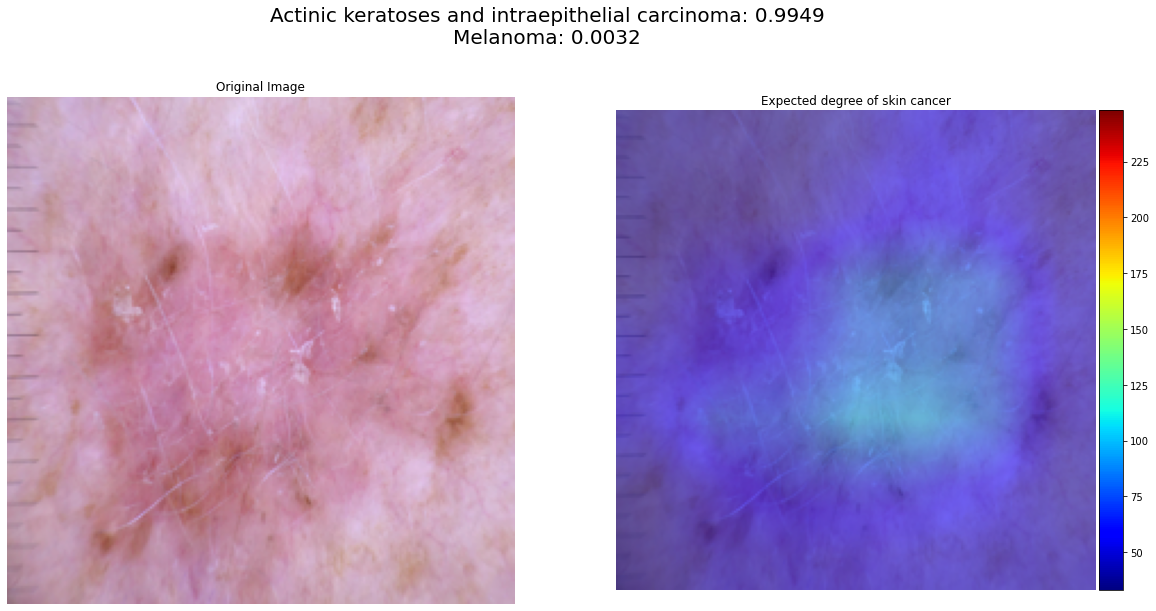

In [7]:
optain_grad_cam_result('./Dataset/Train/ISIC_0026152.jpg', val_transform, model, device)

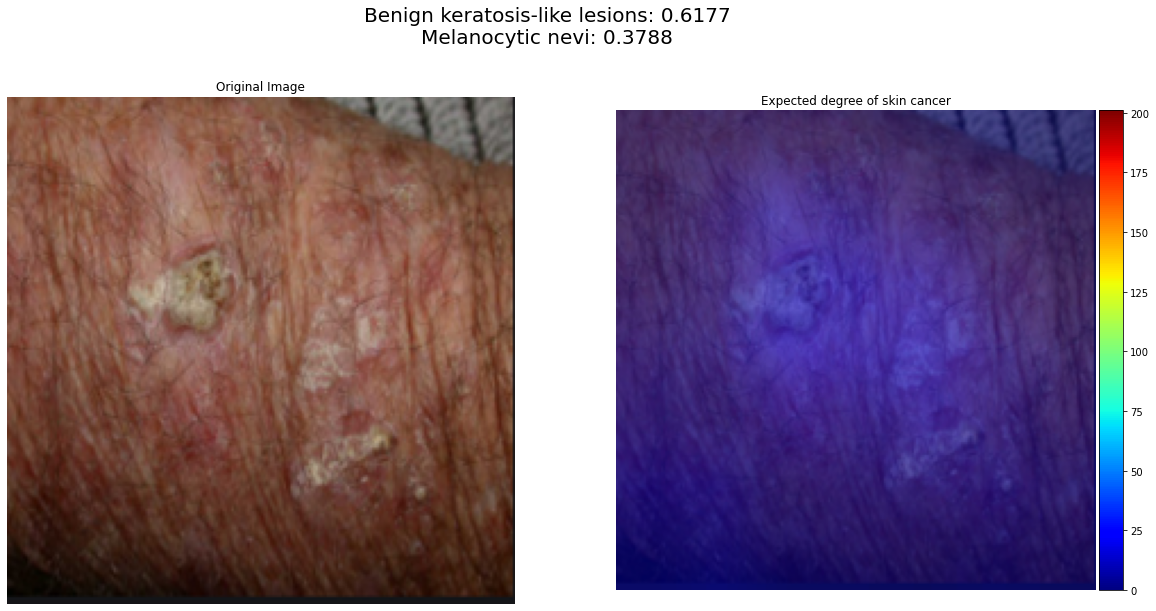

In [8]:
optain_grad_cam_result('./Black_Data/AC_0_1.png', val_transform, model, device)

### Proposed Result of Grad CAM & Prediction

In [9]:
def optain_grad_cam_result2(img_path, val_transform, model, seg_model, back_alpha, device, save_path=None):
    X = Image.open(img_path).convert('RGB')
    origin_img = np.array(X.resize((224, 224)))
    X = val_transform(X)
    X = X.unsqueeze(dim=0)
    return_list = []
    
    # Label List
    label_list = ['Actinic keratoses and intraepithelial carcinoma',
                  'Basal cell carcinoma', 'Benign keratosis-like lesions',
                  'Dermatofibroma', 'Melanocytic nevi', 'Vascular lesions', 'Melanoma']
    
    # Segmentation
    seg_img = seg_model(X.reshape(1,3,224,224).to(device))
    seg_img = torch.round(torch.sigmoid(seg_img))
    seg_img = torch.cat([seg_img, seg_img, seg_img], dim=1)
    seg_img[seg_img == 0] = back_alpha
    X = torch.mul(X, seg_img.cpu()).to(device)
    
    # Prediction
    soft = torch.nn.Softmax(dim=1)
    y = model(X)
    y_ = soft(y)
    y_ = y_.squeeze()
    
    # Grad CAM
    with GradCam(model, [model.features]) as gcam:
        out = gcam(X) # [N, C]
        out[:, torch.argmax(out)].backward()

        gcam_b = gcam.get(model.features) # [N, 1, fmpH, fmpW]
        gcam_b = F.interpolate(gcam_b, [224, 224], mode='bilinear', align_corners=False) # [N, 1, inpH, inpW]
        gcam_b = colorize(gcam_b).squeeze().permute(1,2,0).cpu().detach().numpy()
        
    mixed = gcam_b
    mixed = np.maximum(mixed,0)
    mixed /= np.max(mixed)
    mixed = np.uint8(255*mixed)
    mixed = mixed
    
    result = mixed*0.5 + origin_img*0.5
    result = result.astype('uint8')
    
    for i in range(7):
        one_dict = {'Disease': label_list[i], 'Probability': round(y_[i].item(), 4)}
        return_list.append(one_dict)
    
    # Visualization
    p_list = []
    for r in return_list:
        p_list.append(r['Probability'])
    
    sort_index = np.argsort(-np.array(p_list))
    
    # Top 2 Skin Cancer Type
    result_description= '{}: {}'.format(return_list[sort_index[0]]['Disease'], return_list[sort_index[0]]['Probability'])+'\n'+\
    '{}: {}'.format(return_list[sort_index[1]]['Disease'], return_list[sort_index[1]]['Probability'])
    
    # Visualization
    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(origin_img)
    ax1.set_title('Original Image')
    ax1.axis("off")
 
    ax2 = fig.add_subplot(1, 2, 2)
    im2 = ax2.imshow(result, cmap=plt.cm.jet)
    ax2.set_title('Expected degree of skin cancer')
    ax2.axis("off")


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    plt.suptitle(result_description, fontsize=20)
    
    # Save Figure
    if save_path:
        plt.savefig(save_path, dpi=300)
        
    plt.show()

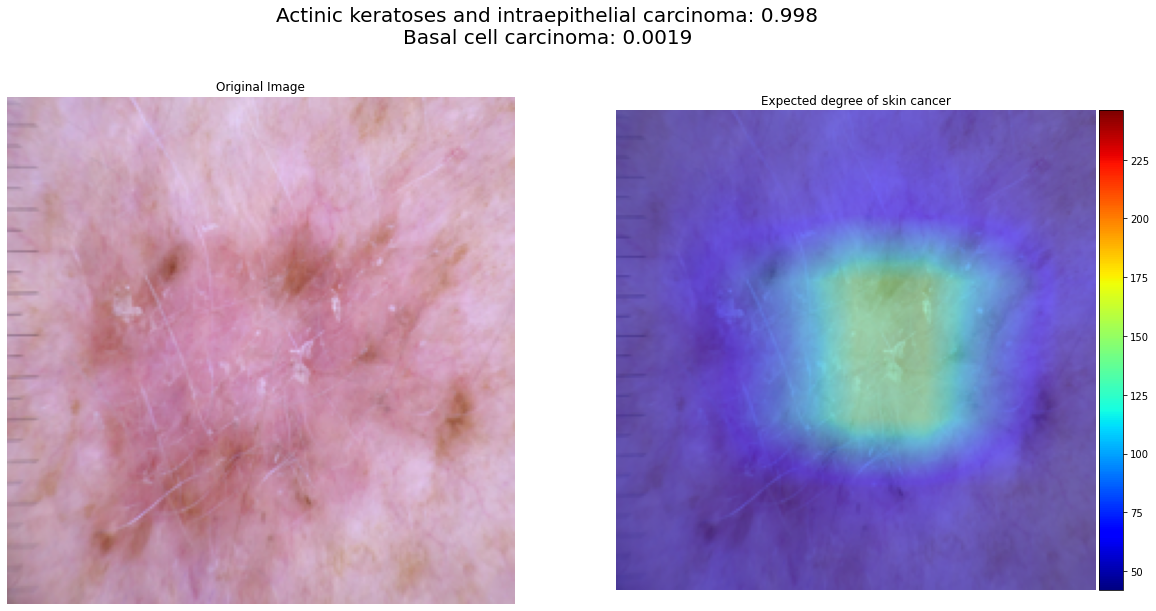

In [10]:
optain_grad_cam_result2('./Dataset/Train/ISIC_0026152.jpg', val_transform, pro_model, seg_model, back_alpha, device)

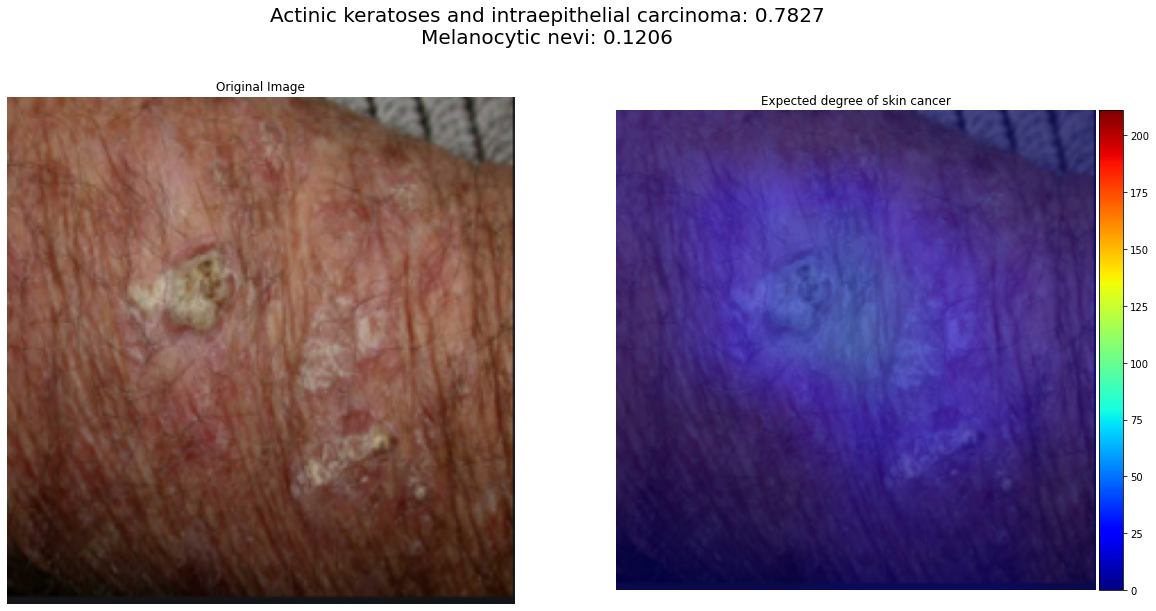

In [11]:
optain_grad_cam_result2('./Black_Data/AC_0_1.png', val_transform, pro_model, seg_model, back_alpha, device, './result.jpg')